<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Gradient-descent-RL" data-toc-modified-id="Gradient-descent-RL-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Gradient-descent RL</a></span></li></ul></div>

In [1]:
variant = "scalar_rgb"
#variant = "cuda_ad_rgb"
#variant = "llvm_ad_rgb"

import os as os
os.environ["MI_DEFAULT_VARIANT"] = variant

import mitsuba as mi
import drjit as dr
import matplotlib.pyplot as plt

mi.set_variant(variant)

In [8]:
import numpy as np
import scipy.ndimage as ndimage
from scipy import misc

In [2]:
from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
import numpy as np
import matplotlib.pyplot as plt
import cv2
import scipy.signal as sig
from scipy.integrate import simpson
from IPython.display import SVG, display, IFrame, HTML
%matplotlib notebook
book = False

C:\Users\meyjoh\repos\vlcompimg\compimg\lib\site-packages\scipy\__init__.py:138: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.4)
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion} is required for this version of "


In [7]:
def make_odd_shapes(inp : np.ndarray) -> np.ndarray:
    if (inp.shape[0] % 2 == 0):
        inp = inp[0:-1,:]
    if (inp.shape[1] % 2 == 0):
        inp = inp[:,0:-1]
    return inp

In [3]:
def pad_like(inp : np.ndarray, like : np.ndarray):
    to_pad = tuple(np.int32((np.array(like.shape) - np.array(inp.shape))/2))
    return np.pad(inp, ((to_pad[0], to_pad[0]), (to_pad[1], to_pad[1])))

In [4]:
def fourier_conv(img:np.ndarray, kernel:np.ndarray) -> np.ndarray:
    
    img_fft = np.fft.fft2(img)
    
    kernel_padded = pad_like(kernel, img)
    kernel_padded_fft = np.fft.fft2(np.fft.ifftshift(kernel_padded))
    
    result = np.real(np.fft.ifft2(img_fft * kernel_padded_fft))
    
        
    return result

In [5]:
def createPillobxResponse(r, x_size, y_size):
    X,Y = np.meshgrid(np.arange(-1*np.floor(x_size/2),np.floor(x_size/2)+1,1), np.arange(-1*np.floor(y_size/2),np.floor(y_size/2)+1,1))
    psf = np.zeros_like(X)
    psf[np.sqrt(X**2+Y**2) <= r] = 1
    return psf, X, Y

In [9]:
s = make_odd_shapes(np.float32(misc.face(gray=True)))

In [10]:
h,_,_ = createPillobxResponse(20, 51,51)
h = 1/np.sum(h) * h

In [11]:
def inverse_filter(g:np.ndarray, h:np.ndarray) -> np.ndarray:
    g_fft = np.fft.fft2(g)
    h_padded = pad_like(h, g)
    h_fft = np.fft.fft2(np.fft.ifftshift(h_padded))
    inv_fft = g_fft / h_fft
    return np.real(np.fft.ifft2(inv_fft))

<IPython.core.display.Javascript object>


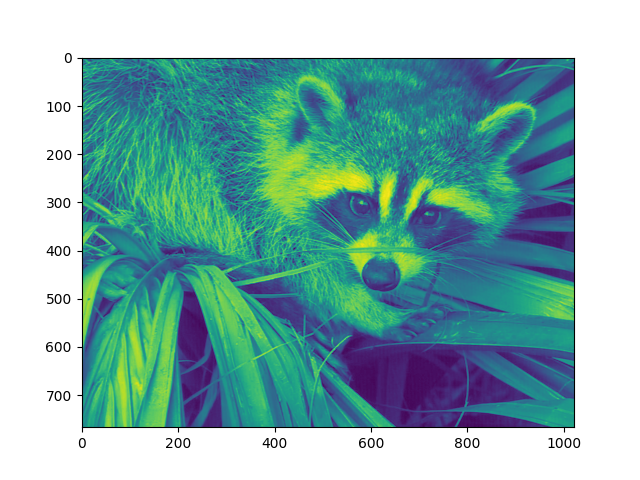

In [12]:
plt.figure()
plt.imshow(inverse_filter(ndimage.convolve(s,h, mode='wrap'), h))

In [93]:
sigmas = np.float32(np.array([0,2,4,8,16,32]))

In [94]:
g = ndimage.convolve(s,h, mode='wrap')
reconsts = []
noises = []
for sigma in sigmas:
    cur_img = g + np.random.normal(0, sigma, g.shape)
    noises.append(cur_img)
    recon = inverse_filter(cur_img, h)
    reconsts.append(recon)

In [ ]:
plt.figure()
for i in range(0,len(reconsts)):
    plt.subplot(len(reconsts),2, 2*i+1, title='moep')
    plt.imshow(noises[i], cmap='gray')
    plt.subplot(len(reconsts),2, 2*i+2)
    plt.imshow(reconsts[i], cmap='gray')
plt.tight_layout()

<IPython.core.display.Javascript object>


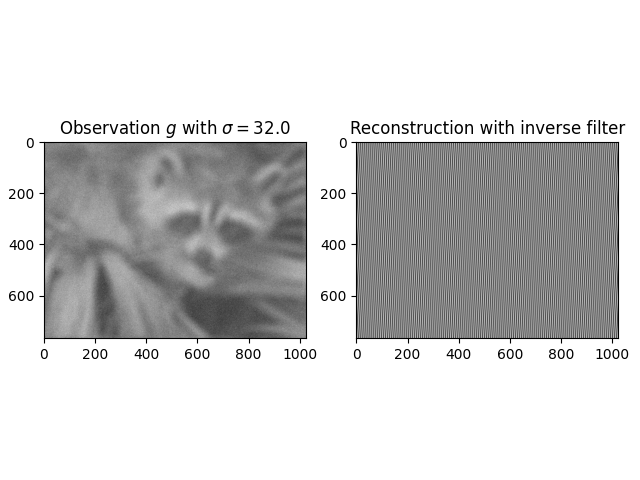

In [96]:
plt.figure()
for i in range(0,len(reconsts)):
    plt.subplot(1,2, 1, title=f'Observation $g$ with $\sigma={sigmas[i]}$')
    plt.imshow(noises[i], cmap='gray')
    plt.subplot(1,2, 2, title="Reconstruction with inverse filter")
    plt.imshow(reconsts[i], cmap='gray')
    plt.tight_layout()
    plt.savefig(f"figures/6/inv_filter_res_{i+1}.svg", dpi=1000)


In [13]:
def mag_square(inp : np.ndarray):
    return inp.real**2 + inp.imag**2

In [14]:
def wiener_filter(g:np.ndarray, h:np.ndarray) -> np.ndarray:
    g_fft = np.fft.fft2(g)
    h_padded = pad_like(h, g)
    h_fft = np.fft.fft2(np.fft.ifftshift(h_padded))
    
    X,Y = np.meshgrid(np.arange(1,g.shape[1]+1), np.arange(1,g.shape[0]+1))
    
    snr = (1 / np.sqrt(X**2 + Y**2))
    
    #print(f"snr.shape:{snr.shape}, g_fft.shape:{g_fft.shape}")
    
    inv_fft = g_fft * np.conjugate(h_fft) / (mag_square(h_fft) + snr)
    return np.real(np.fft.ifft2(inv_fft))

In [106]:
def wiener_reconstruction(img, kernel, inv_snr):
    kernel_padded = pad_like(kernel, img)
    kernel_fft = np.fft.fft2(np.fft.fftshift(kernel_padded))
    wiener = np.conjugate(kernel_fft)/(mag_square(kernel_fft) + inv_snr)
    
    return np.fft.ifft2(np.fft.fft2(img) * wiener).real

<IPython.core.display.Javascript object>


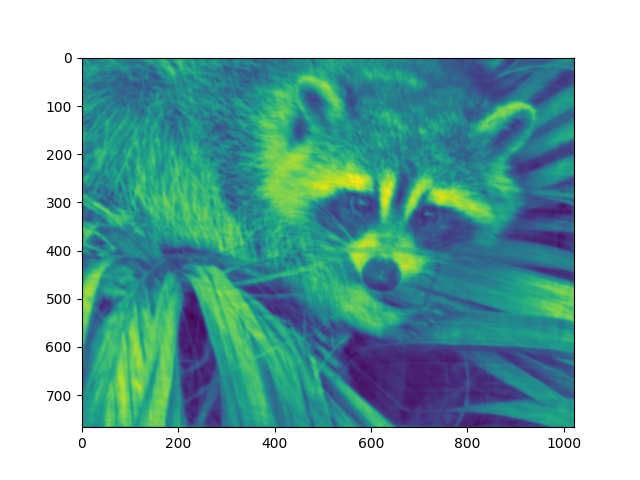

In [108]:
plt.figure()
plt.imshow(wiener_filter(ndimage.convolve(s,h, mode='wrap'), h))

In [110]:
g = ndimage.convolve(s,h, mode='wrap')
wiener_reconsts = []
noises = []
for sigma in sigmas:
    #cur_img = g + np.random.normal(0, sigma, g.shape)
    cur_img = g + np.random.randn(g.shape[0], g.shape[1])*sigma

    noises.append(cur_img)
    recon = wiener_filter(cur_img, h)
    wiener_reconsts.append(recon)

<IPython.core.display.Javascript object>


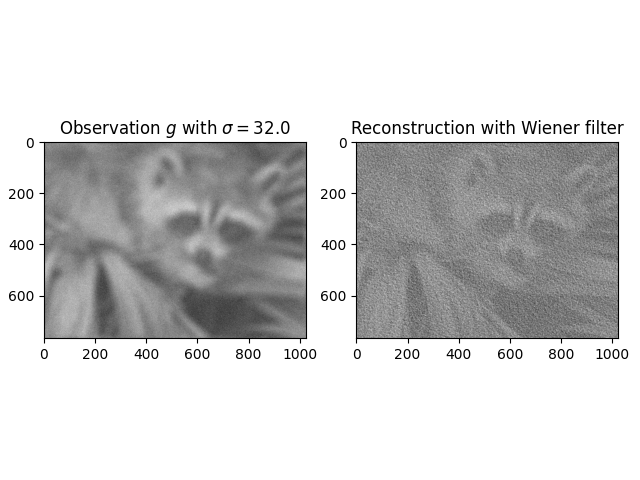

In [111]:
plt.figure()
for i in range(0,len(reconsts)):
    plt.subplot(1,2, 1, title=f'Observation $g$ with $\sigma={sigmas[i]}$')
    plt.imshow(noises[i], cmap='gray')
    plt.subplot(1,2, 2, title="Reconstruction with Wiener filter")
    plt.imshow(wiener_reconsts[i], cmap='gray')
    plt.tight_layout()
    plt.savefig(f"figures/6/wiener_filter_res_{i+1}.svg", dpi=500)


## Gradient-descent RL

In [84]:
def fourier_conv(img:np.ndarray, kernel:np.ndarray) -> np.ndarray:
    
    img_fft = np.fft.fft2(img)
    
    kernel_padded = pad_like(kernel, img)
    kernel_padded_fft = np.fft.fft2(np.fft.ifftshift(kernel_padded))
    
    result = np.real(np.fft.ifft2(img_fft * kernel_padded_fft))
    
        
    return result

In [82]:
def grad_RL(img:np.ndarray, kernel:np.ndarray, lr:float, n_iter:int):
    s_old = np.float32(img)
    s_list = []
    diff_list = []
    
    for i in range(0,n_iter):
        s_new = s_old - lr * ndimage.convolve((1 - img/ndimage.convolve(s_old,kernel,mode='reflect')), kernel.transpose(), mode='reflect')
        diff = np.sum(np.abs(s_new - s_old))
        diff_list.append(diff)
        print(diff)
        s_list.append(s_new)
        s_old = s_new
    
    return s_old, s_list
        

In [85]:
def grad_RL(img:np.ndarray, kernel:np.ndarray, lr:float, n_iter:int):
    s_old = np.float32(img)
    s_list = []
    diff_list = []
    
    for i in range(0,n_iter):
        s_new = s_old - lr * fourier_conv((1 - img/fourier_conv(s_old,kernel)), kernel.transpose())
        diff = np.sum(np.abs(s_new - s_old))
        diff_list.append(diff)
        print(diff)
        s_list.append(s_new)
        s_old = s_new
    
    return s_old, s_list
        

In [92]:
def mult_RL(img:np.ndarray, kernel:np.ndarray, lr:float, n_iter:int):
    s_old = np.float32(img)
    s_list = []
    diff_list = []
    
    for i in range(0,n_iter):
        s_new = s_old * fourier_conv(img / fourier_conv(s_old, kernel), kernel.transpose())
        diff = np.sum(np.abs(s_new - s_old))
        diff_list.append(diff)
        print(diff)
        s_list.append(s_new)
        s_old = s_new
    
    return s_old, s_list
        

In [90]:
g = ndimage.convolve(s,h, mode='wrap')

In [ ]:

g_ = g + np.random.randn(g.shape[0], g.shape[1])*2

<IPython.core.display.Javascript object>


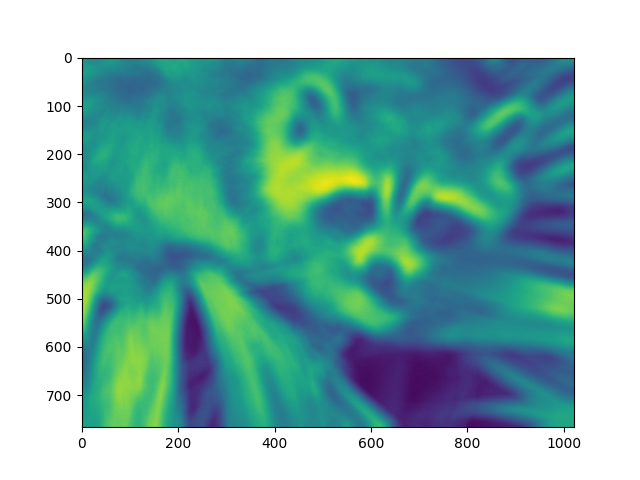

In [83]:
plt.figure()
plt.imshow(g_)

In [91]:
shat, shat_list = grad_RL(np.float32(g_), np.float32(h), 15, 400)

358048.4924992838
304242.05776491744
268368.16098073736
241669.77091070137
221042.03835581642
203873.0832907385
189212.0338309682
176492.65116472225
165345.2284484565
155487.2600111875
146710.87807362658
138855.25789995008
131773.4221756479
125350.6797464284
119492.34719464765
114127.45440250929
109198.89464129739
104656.51612221832
100459.69366187775
96575.48910184056
92972.52176251293
89622.38761772517
86499.72447195105
83582.68822994895
80854.1813437142
78298.87839229427
75901.45417280667
73649.42593851952
71532.02873689953
69538.61246854403
67658.29360572137
65882.14079566077
64202.71650274795
62613.65004122564
61108.55259283029
59681.10869795835
58325.68324726383
57037.52087277672
55811.29024176418
54642.73951198113
53528.44416569196
52464.984687135504
51449.285087429176
50478.4974327624
49550.07366559536
48661.304896357775
47809.85192575093
46993.50546465043
46210.840352832915
45459.57976457801
44737.93239094632
44044.06857791281
43376.547876453114
42734.00830039699
42115.2062283

In [95]:
shat, shat_list = mult_RL(np.float32(g_), np.float32(h), 15, 400)

2023212.0621653537
1066781.0039131988
738378.1368795156
565637.0386916553
459429.50695089815
387735.12921650766
336529.2198045974
298386.69319859013
269016.1759630144
245840.23954211146
227231.9913855185
212009.85637454034
199337.90937851943
188665.73697499826
179563.48037916888
171709.94035979855
164858.28769584894
158823.22356354835
153463.0384044108
148660.14455148453
144320.64461306055
140371.45494433393
136752.72787620663
133417.11436308958
130325.30732432462
127443.44899015897
124745.70201612145
122210.0623333331
119816.64492240008
117549.87694265675
115395.40316468084
113342.94604929278
111382.70706936336
109506.89893572377
107708.53483205797
105981.55572643231
104321.24795929917
102722.40780697789
101180.62581740055
99692.3841514384
98253.57511120259
96861.6663002877
95513.73004048727
94206.93076741706
92938.60168346833
91707.41352524841
90511.22622116268
89348.05868009829
88216.18081076167
87114.27451920797
86040.92009401345
84994.88640424203
83975.41095685186
82981.5020642394

<IPython.core.display.Javascript object>


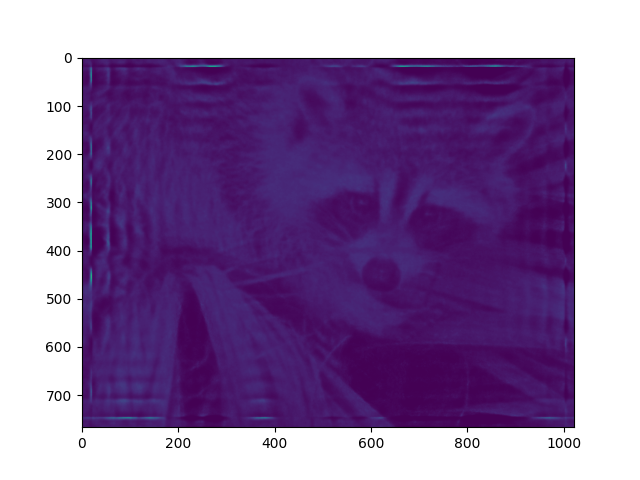

In [99]:
plt.figure()
plt.imshow(shat)

<IPython.core.display.Javascript object>


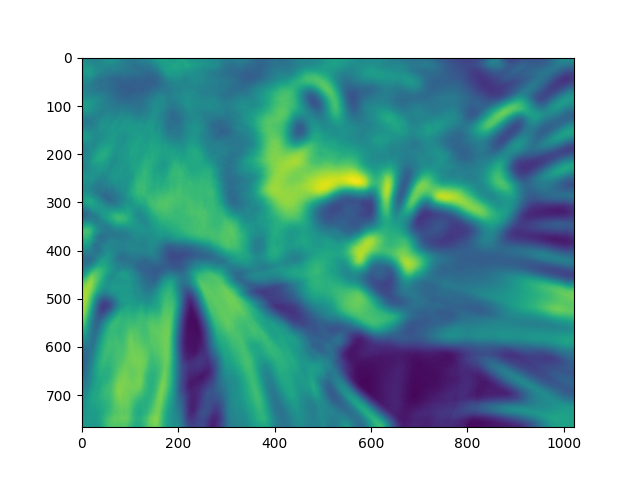

interactive(children=(IntSlider(value=0, description='i', max=399, step=20), Output()), _dom_classes=('widget-…

<function __main__.<lambda>(i)>

In [98]:
plt.figure()
interact(lambda i: plt.imshow(shat_list[i]), i=widgets.IntSlider(min=0, max=len(shat_list)-1, step=20, value=0))